# Teste de Hipóteses - Teste A/B - Z test

Guia prático para realização de:

 - Teste de Hipóteses
 - Teste A/B
 - Teste Z
 - Calculo de Power
 - Calculo de Valor Z
 - Calculo de Valor P
 - Plot de distribuições

In [16]:
# Importando bibliotecas

import scipy.stats as scs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [17]:
# Função para gerar os dados

def generate_data(N_A, N_B, p_A, p_B, control_label='A', test_label='B'):

    data = []

    N = N_A + N_B

    group_bern = scs.bernoulli(0.5)

    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [26]:
# Gerando os dados

N_A = 500
N_B = 550
bcr = 0.09  # baseline conversion rate
d_hat = 0.12  # difference between the groups

ab_data = generate_data(N_A, N_B, bcr, d_hat)

In [27]:
# Visualizando dataframe

ab_data.head(2)

,converted,group
0,0,B
1,0,B


In [28]:
# Transformando dados

data = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
data['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
data['rate'] = ab_data.pivot_table(values='converted', index='group')
data

,converted,total,rate
group,,,
A,52,539,0.096475
B,72,511,0.140900


__Distribuição de Bernoulli__:

    Var = p * (1 - p)

As distribuição das probabilidades obedece uma __Distribuição Normal__, onde o erro padrão é

    std = sqrt ((p * (1 - p)) / n )

In [35]:
# Plot da distribuição das probabilidades (distribuição normal)

p_A = data.rate[0]
p_B = data.rate[1]
A_total = data.total[0]
B_total = data.total[1]

SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)

print("Std de A: {}".format(SE_A))
print("Std de B: {}".format(SE_B))

Std de A: 0.012716951197487556
Std de B: 0.015391011338929061


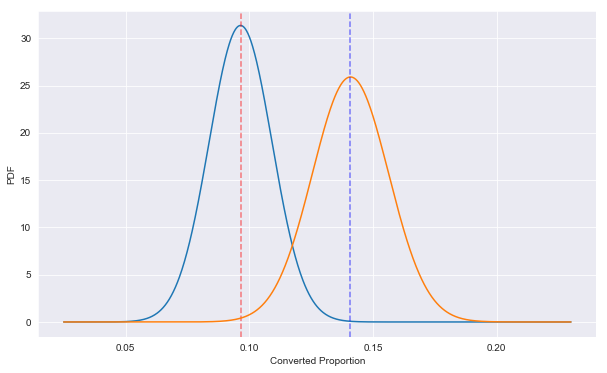

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(.025, .23, 1000)
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(x, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(x, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Converted Proportion')
plt.ylabel('PDF')
plt.show()

### Teste de Hipóteses:

__H0 - Hipótese Nula__: A alteração de A para B __não provoca mudança__ na taxa de conversão.

__H1 - Hipótese Alternativa__: A alteração de A para B __provoca mudança__ na taxa de conversão.

__Nível de significância (ALPHA)__: Definido antes do teste (frequentemenet 0.05 ou 5%), é o nível que determina a proporção dos resultados amostrais como sendo devido ao acaso. Também é igual a probabilidade de se rejeitar a hipótese nula quando ela é verdadeira (Erro tipo 1)

__Power__: é a probabilidade de rejeitar a hipótese nula, sendo a hipótese nula falsa.

Tipos de erros:

<img src="hypothesis_testing.png" alt="Drawing" style="width: 500px;"/>

Plot dos possíveis resultados do teste de hipóteses:

<img src="TypesError.png" alt="Drawing" style="width: 500px;"/>

__Teste de estatística__:

    d = p_B - p_A
    
    O desvio padrão agrupado é
    
    std_d = sqrt (((p_A * (1 - p_A)) / n_A) + ((p_B * (1 - p_B)) / n_B))
    
    ou
    
    std_d = sqrt (p_P * (1 - p_P) * ((1/n_A) + (1/n_B)))
    
    onde p_P é a probabilidade agrupada:
    
    p_P = ((p_A * n_A + p_B * n_B) / (n_A + n_B))

In [30]:
# Calculando 'd' e o desvio padrão agrupado

d = p_B - p_A

std_d = np.sqrt(((p_A * (1 - p_A)) / A_total) + ((p_B * (1 - p_B)) / B_total))

print("d: {} \nstd_d: {}".format(d, std_d))

d: 0.04442524207690547 
std_d: 0.019965071444758797


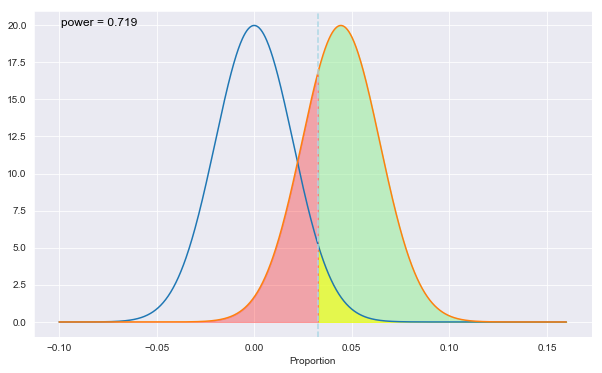

In [31]:
# Plot das distribuições de probabilidade das hipóteses
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(-0.1, .16, 1000)
yA = scs.norm(0, std_d).pdf(x)
ax.plot(x, yA)
yB = scs.norm(d, std_d).pdf(x)
ax.plot(x, yB)

# Determinando e desenhando a linha de nível de significância 0.05
alpha = 0.05
z = scs.norm().ppf(1 - alpha)
confidence_interval = z*std_d
ax.axvline(x=confidence_interval, c='lightblue', linestyle='--')
plt.xlabel('Proportion')

ax.fill_between(x, 0, yB, color='lightgreen', alpha='0.5', where=(x > confidence_interval))
ax.fill_between(x, 0, yA, color='yellow', alpha='0.6', where=(x > confidence_interval))
ax.fill_between(x, 0, yB, color='red', alpha='0.3', where=(x < confidence_interval))

null = scs.norm(0, std_d)
alternative = scs.norm(d, std_d)

# Calculando power
ax.text(-3 * std_d, null.pdf(0), 'power = {0:.3f}'.format(1 - alternative.cdf(confidence_interval)), fontsize=12, ha='right', color='k')

plt.show()

### Z-test:

T-test é o teste estatístico mais comum para comparar dois grupos e poderia ser usado aqui. 
Mas o teste mais correto é, no entanto, o teste z para comparar duas PROPORÇÕES.

O seguinte deve ser verdadeiro para z-tests:
1. As duas amostras devem ser independentes.
2. Os tamanhos das amostras devem ser suficientemente grandes (> 30) para a distribuição a ser aplicada.
3. As amostras devem ser selecionadas aleatoriamente.

__Z_score__:

    Z = ((p_B - p_A) / std_d)

In [32]:
# Calculando Z score

Z = (p_B - p_A) / std_d

print("z score: {}".format(Z))

z score: 2.225148164374234


__p_value__:

    O valor-p é a chance de obter uma estatística de teste mais extrema assumindo que a hipótese nula seja verdadeira.

    Corresponde a integral da porção da distribuição normal à direita do valor Z.

In [33]:
# Calculando valor p

p_value = 1 - scs.norm.cdf(Z)

print("p value: {}".format(p_value))

p value: 0.013035646654604438


In [34]:
if p_value > 0.05:
    print("O valor p é maior que o nível de significancia alpha = 0.05, logo a hípotese nula não pode ser rejeitada, e estatísticamente não há diferença entre A e B")
else:
    print("O valor p é menor que o nível de significancia alpha = 0.05, logo a hípotese nula deve ser rejeitada, e estatísticamente há diferença entre A e B")

O valor p é menor que o nível de significancia alpha = 0.05, logo a hípotese nula deve ser rejeitada, e estatísticamente há diferença entre A e B


#### Bibliografia:

https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f